In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Create data directory paths
training_path = "data/custom/train"
testing_path = "data/custom/test"

In [3]:
# Create dataset class for monitoring preprocessing
class MainDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform = transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]
        
    @property
    def classes(self):
        return self.data.classes

In [4]:
# Confirm data loads properly
dataset = MainDataset(data_dir = training_path)

In [5]:
len(dataset)

240

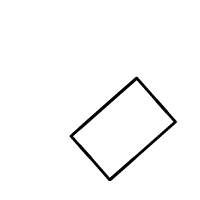

In [6]:
dataset[0]
image, label = dataset[115]
image

In [7]:
# Create dictionary for classes to associate images with
target_to_class = {value: key for key, value in ImageFolder(training_path).class_to_idx.items()}
print(target_to_class)

{0: 'oval', 1: 'rectangle', 2: 'stickman', 3: 'triangle'}


In [8]:
# Create image transforms to use in ImageFolder class (could have done this earlier but wanted to test first)
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

In [9]:
# Apply image transforms to data
dataset = MainDataset(data_dir = training_path, transform = transform)

In [10]:
image, label = dataset[25]
image.shape

torch.Size([3, 200, 200])

In [11]:
# Create data loader out of dataset
dataloader = DataLoader(dataset, 
                        batch_size = 32, 
                        shuffle = True)

In [12]:
# Confirm data loader is working properly by checking shape and 
# label order (should shuffle everytime code is run)
for images, labels in dataloader:
    break

print(images.shape)
print(labels.shape)

torch.Size([32, 3, 200, 200])
torch.Size([32])


In [13]:
labels

tensor([2, 0, 2, 3, 2, 0, 3, 1, 2, 2, 2, 1, 2, 0, 1, 0, 0, 1, 3, 0, 2, 3, 3, 2,
        0, 1, 2, 3, 3, 1, 0, 3])

In [14]:
# Create the model
class Classifier(nn.Module):
    def __init__(self, num_classes = 4):
        super(Classifier, self).__init__()
        
        # Defining parts of the model
        self.base_model = timm.create_model("efficientnet_b0", pretrained = False)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        
        # Make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)
        
    def forward(self, x):

        # Connect these parts and return output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [15]:
model = Classifier(num_classes = 4)
print(str(model)[:500])

Classifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
     


In [16]:
example_out = model(images)
example_out.shape

torch.Size([32, 4])

In [17]:
# Create loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [18]:
criterion(example_out, labels)

tensor(1.4099, grad_fn=<NllLossBackward0>)

In [19]:
# Create training/validation datasets

transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

train_folder = "data/custom/train"
val_folder = "data/custom/test"

train_dataset = MainDataset(train_folder, transform = transform)
val_dataset = MainDataset(val_folder, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

In [20]:
# Create training loop
num_epoch = 15
train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []
model = Classifier(num_classes = 4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epoch):
    # Set model to train
    model.train()
    running_loss = 0.0
    train_n_correct = 0
    train_n_total = 0

    # Loop through training data loader
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)

        _, train_predicted = torch.max(outputs.data, 1)
        train_n_total += labels.size(0)
        train_n_correct += (train_predicted == labels).sum().item()

    train_loss = round(running_loss / len(train_loader.dataset), 5)
    train_losses.append(train_loss)
    train_acc = round(train_n_correct / len(train_loader.dataset), 5)
    train_accuracy.append(train_acc)

    # Validation phase
    model.eval()
    running_loss = 0.0
    val_n_correct = 0
    val_n_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
            _, val_predicted = torch.max(outputs.data, 1)
            val_n_total += labels.size(0)
            val_n_correct += (val_predicted == labels).sum().item()
        
        val_loss = round(running_loss / len(val_loader.dataset), 5)
        val_losses.append(val_loss)
        val_acc = round(val_n_correct / len(val_loader.dataset), 5)
        val_accuracy.append(val_acc)

    # Print epoch stats
    print(f"Epoch {epoch + 1} / {num_epoch} - Train loss: {train_loss}, Validation loss: {val_loss}")
    print(f"Training Accuracy: {train_acc}, Validation accuracy: {val_acc}")

Epoch 1 / 15 - Train loss: 1.45689, Validation loss: 1.43607
Training Accuracy: 0.26667, Validation accuracy: 0.25
Epoch 2 / 15 - Train loss: 1.09889, Validation loss: 1.55074
Training Accuracy: 0.50833, Validation accuracy: 0.25
Epoch 3 / 15 - Train loss: 0.66871, Validation loss: 1.68067
Training Accuracy: 0.76667, Validation accuracy: 0.25
Epoch 4 / 15 - Train loss: 0.29128, Validation loss: 1.76591
Training Accuracy: 0.90833, Validation accuracy: 0.25
Epoch 5 / 15 - Train loss: 0.15474, Validation loss: 1.8877
Training Accuracy: 0.95417, Validation accuracy: 0.25
Epoch 6 / 15 - Train loss: 0.18998, Validation loss: 2.74727
Training Accuracy: 0.9375, Validation accuracy: 0.35
Epoch 7 / 15 - Train loss: 0.12711, Validation loss: 1.49223
Training Accuracy: 0.95833, Validation accuracy: 0.4
Epoch 8 / 15 - Train loss: 0.16279, Validation loss: 3.74603
Training Accuracy: 0.95417, Validation accuracy: 0.25
Epoch 9 / 15 - Train loss: 0.19374, Validation loss: 10.46673
Training Accuracy: 0.

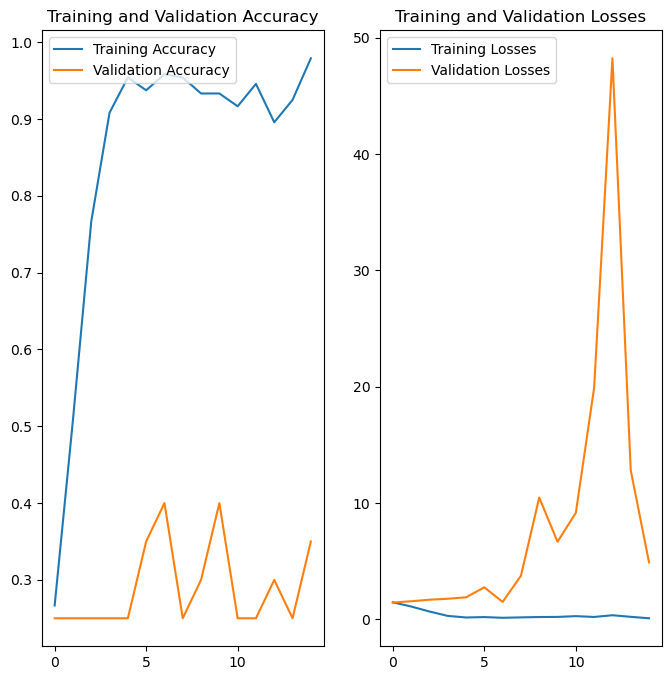

In [37]:
# Plot evaluation results
plt.figure(figsize = (8, 8))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.legend(loc = "upper left")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label = "Training Losses")
plt.plot(val_losses, label = "Validation Losses")
plt.legend(loc = "upper left")
plt.title("Training and Validation Losses")

plt.show()